In [19]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# Basic imports
try:
    from xhydro.extreme_value_analysis.parameterestimation import *
    has_julia = True
except ImportError:
    print(
        "This notebook requires the `julia` programming language and the `juliacall` Python package to be installed."
    )
    has_julia = False

import warnings
import pandas as pd
import pooch
import matplotlib.pyplot as plt
# warnings.simplefilter("always", UserWarning)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Données

In [20]:
GITHUB_URL = "https://github.com/hydrologie/xhydro-testdata"
BRANCH_OR_COMMIT_HASH = "main"

data = pooch.retrieve(
    url=f"{GITHUB_URL}/raw/{BRANCH_OR_COMMIT_HASH}/data/extreme_value_analysis/NOAA_GFDL_ESM4.zip",
    known_hash="md5:6c0f51c59add2f37b0e4af169b7eb7f6",
    processor=pooch.Unzip(),
)

df = pd.read_csv(data[0])
ds = df.to_xarray()
ds = ds.set_coords(
    ["time", "station_num", "station_name"]
)
ds = ds.set_index(index=["station_num", "time"])
ds = ds.unstack("index")
ds

<xarray.Dataset> Size: 455kB
Dimensions:          (station_num: 97, time: 146)
Coordinates:
  * station_num      (station_num) int64 776B 1001 1004 1008 ... 15403 15414
  * time             (time) object 1kB '1955-01-01' ... '2100-01-01'
    station_name     (station_num, time) object 113kB 'Dozois' ... 'Romaine 4...
Data variables:
    qmax_yearly      (station_num, time) float64 113kB 424.0 805.1 ... 711.7
    total_precip     (station_num, time) float64 113kB 983.6 ... 1.065e+03
    max_temp_yearly  (station_num, time) float64 113kB 8.0 8.1 8.1 ... 4.4 4.6

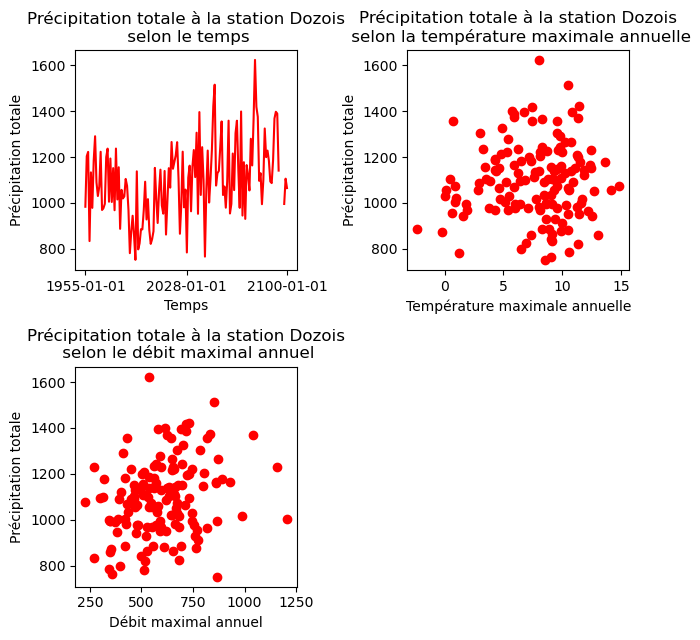

In [21]:
plt.rcParams["figure.figsize"] = [6.5, 6.5]  # Adjust the figure size
plt.rcParams["figure.autolayout"] = True

# First subplot
plt.subplot(2, 2, 1)  # 2x2 grid, first plot
y = ds.total_precip[0, :].values
x_1 = ds.time.values
plt.title("Précipitation totale à la station Dozois\n selon le temps")
plt.xlabel("Temps")
plt.ylabel("Précipitation totale")
plt.plot(x_1, y, color="red")

# Custom x-axis ticks
first_year = x_1[0]
last_year = x_1[-1]
middle_index = len(x_1) // 2
middle_year = x_1[middle_index]
plt.xticks([first_year, middle_year, last_year])

# Second subplot
plt.subplot(2, 2, 2)  # 2x2 grid, second plot
x_2 = ds.max_temp_yearly[0, :].values
plt.title("Précipitation totale à la station Dozois\n selon la température maximale annuelle")
plt.xlabel("Température maximale annuelle")
plt.ylabel("Précipitation totale")
plt.scatter(x_2, y, color="red")

# Third subplot
plt.subplot(2, 2, 3)  # 2x2 grid, third plot
x_3 = ds.qmax_yearly[0, :].values
plt.title("Précipitation totale à la station Dozois\n selon le débit maximal annuel")
plt.xlabel("Débit maximal annuel")
plt.ylabel("Précipitation totale")
plt.scatter(x_3, y, color="red")

# Fourth subplot (empty)
plt.subplot(2, 2, 4)  # 2x2 grid, fourth plot (left empty)
plt.axis('off')  # Turn off the axis

plt.show()


## Estimation de paramètres - Stationnaire


In [22]:
params = fit(ds, dist="genextreme", method="ml", vars=["total_precip"])
params

<xarray.Dataset> Size: 8kB
Dimensions:             (station_num: 97, dparams: 3)
Coordinates:
  * station_num         (station_num) int64 776B 1001 1004 1008 ... 15403 15414
  * dparams             (dparams) <U5 60B 'shape' 'loc' 'scale'
Data variables:
    total_precip        (station_num, dparams) float64 2kB -0.1816 ... 148.2
    total_precip_lower  (station_num, dparams) float64 2kB -0.2766 ... 130.3
    total_precip_upper  (station_num, dparams) float64 2kB -0.08659 ... 168.5
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-08-22 10:32:34] fit: Estimate distribution parameters...

## Estimation de paramètres - Non-Stationnaire

In [23]:
params = fit(ds, dist="genextreme", method="ml", vars=["total_precip"], locationcov=["max_temp_yearly"], distributed=True)
params

<xarray.Dataset> Size: 11kB
Dimensions:             (station_num: 97, dparams: 4)
Coordinates:
  * station_num         (station_num) int64 776B 1001 1004 1008 ... 15403 15414
  * dparams             (dparams) <U29 464B 'shape' 'loc' ... 'scale'
Data variables:
    total_precip        (station_num, dparams) float64 3kB -0.1838 ... 148.3
    total_precip_lower  (station_num, dparams) float64 3kB -0.2783 ... 130.4
    total_precip_upper  (station_num, dparams) float64 3kB -0.08928 ... 168.6
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-08-22 10:32:38] fit: Estimate distribution parameters...

## Estimation de paramètres - Stationnaire: Attention au 0 dans l'intervalle!

In [24]:
params = fit(ds, dist="genextreme", method="ml", vars=["total_precip"], locationcov=["max_temp_yearly"], shapecov=["qmax_yearly"], distributed=True)
params

<xarray.Dataset> Size: 13kB
Dimensions:             (station_num: 97, dparams: 5)
Coordinates:
  * station_num         (station_num) int64 776B 1001 1004 1008 ... 15403 15414
  * dparams             (dparams) <U29 580B 'shape' ... 'scale'
Data variables:
    total_precip        (station_num, dparams) float64 4kB -0.3134 ... 148.8
    total_precip_lower  (station_num, dparams) float64 4kB -0.7115 ... 130.7
    total_precip_upper  (station_num, dparams) float64 4kB 0.08478 ... 169.4
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-08-22 10:32:43] fit: Estimate distribution parameters...

## Niveau de retour - Stationnaire

In [25]:
return_level_quantiles_stat = return_level(ds, dist="genextreme", method="ml", vars=["total_precip"], return_period=1000)
return_level_quantiles_stat

<xarray.Dataset> Size: 2kB
Dimensions:       (station_num: 97, return_level: 1)
Coordinates:
  * station_num   (station_num) int64 776B 1001 1004 1008 ... 14586 15403 15414
  * return_level  (return_level) <U12 48B 'return_level'
Data variables:
    total_precip  (station_num, return_level) float64 776B 1.638e+03 ... 1.65...
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-08-22 10:32:44] fit: Estimate distribution parameters...

## Niveau de retour - Non-Stationnaire

In [26]:
return_level_quantiles_nstat = return_level(ds, dist="genextreme", method="ml", vars=["total_precip"], return_period=1000, locationcov=["max_temp_yearly"], shapecov=["qmax_yearly"], distributed=True)
# print(return_level_quantiles_nstat.total_precip[0, :].values)
return_level_quantiles_nstat

<xarray.Dataset> Size: 115kB
Dimensions:       (station_num: 97, return_level: 146)
Coordinates:
  * station_num   (station_num) int64 776B 1001 1004 1008 ... 14586 15403 15414
  * return_level  (return_level) object 1kB '1955-01-01' ... '2100-01-01'
Data variables:
    total_precip  (station_num, return_level) float64 113kB 1.576e+03 ... nan
Attributes:
    long_name:    genextreme parameters
    description:  Parameters of the genextreme distribution
    method:       ML
    estimator:    Maximum likelihood
    scipy_dist:   genextreme
    units:        
    history:      [2024-08-22 10:32:46] fit: Estimate distribution parameters...

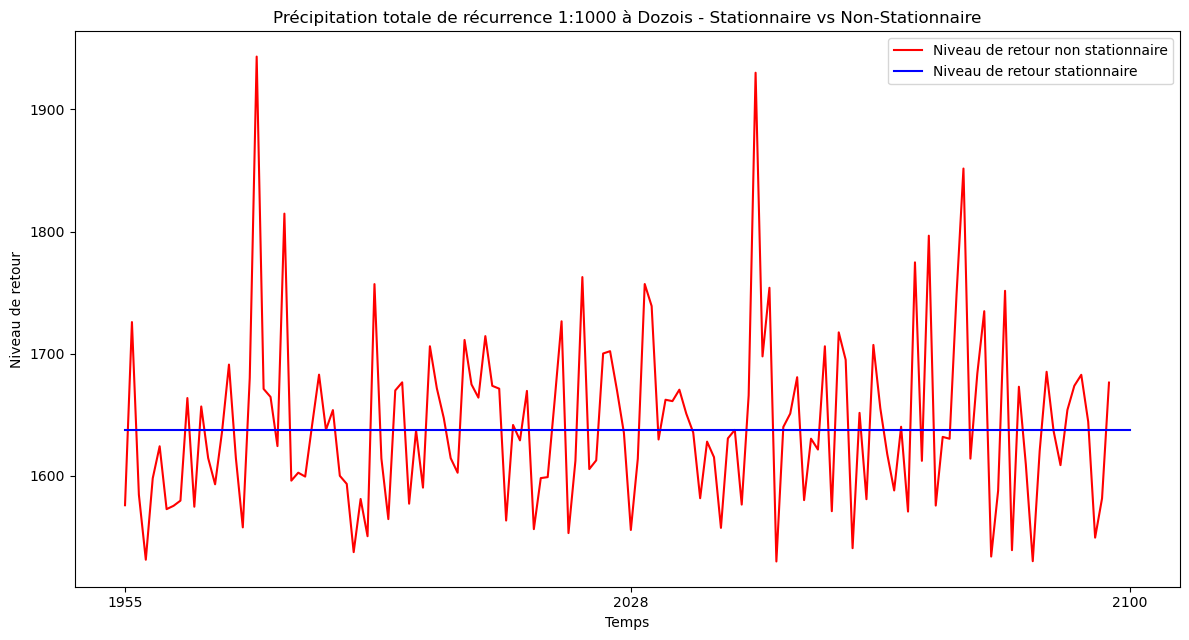

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert string dates to datetime objects
x = pd.to_datetime(ds.time.values)

plt.rcParams["figure.figsize"] = [12, 6.5]  
plt.rcParams["figure.autolayout"] = True

y_1 = return_level_quantiles_nstat.total_precip[0, :].values
y_2 = [return_level_quantiles_stat.total_precip[0, :].values for _ in range(len(y_1))]

plt.title("Précipitation totale de récurrence 1:1000 à Dozois - Stationnaire vs Non-Stationnaire")
plt.xlabel("Temps")
plt.ylabel("Niveau de retour")

# Custom x-axis ticks
first_year = x[0]
last_year = x[-1]
middle_year = x[len(x) // 2]
plt.xticks([first_year, middle_year, last_year], labels=[first_year.year, middle_year.year, last_year.year])

# Plot both y_1 and y_2
plt.plot(x, y_1, color="red", label="Niveau de retour non stationnaire")
plt.plot(x, y_2, color="blue", label="Niveau de retour stationnaire")
plt.legend()
plt.show()
